# Import library

In [39]:
from tensorflow.keras.preprocessing.image import img_to_array
import cv2
import numpy as np
import os
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from matplotlib.pyplot import show
import matplotlib.pyplot as plt
from imutils import paths
import pickle

# Preprocessing

In [40]:
class ImageToArrayPreprocessor:  # Tạo lớp để chuyển ảnh --> mảng
    def __init__(self, dataFormat=None):
        # Lưu ảnh đã được định dạng
        self.dataFormat = dataFormat

    def preprocess(self, image): # Định nghĩa phương thức preprocess trả về mảng
        # Hàm img_to_array của Keras
        return img_to_array(image, data_format=self.dataFormat)

In [41]:
class SimplePreprocessor:
    def __init__(self, width, height, inter=cv2.INTER_AREA):
        # Lưu image width, height và interpolation
        self.width = width
        self.height = height
        self.inter = inter

    def preprocess(self, image):
        # Trả về ảnh có kích thước đã thay đổi
        return cv2.resize(image, (self.width, self.height), interpolation=self.inter)


# Dataset loader

In [42]:
class SimpleDatasetLoader:
    def __init__(self, preprocessors=None):
        # Lưu ảnh tiền xử lý
        self.preprocessors = preprocessors

        # Nếu bước tiền xử lý là None thì khởi tạo danh sách rỗng
        if self.preprocessors is None:
            self.preprocessors = []

    def load(self, imagePaths, verbose=-1):
        # Khởi tạo danh sách các đặc trưng và nhãn
        data = []
        labels = []

        # Lặp qua tất cả ảnh đầu vào
        for (i, imagePath) in enumerate(imagePaths):
            # Nạp ảnh và trích xuất nhãn từ đường dẫn định dạng
            # /path/to/dataset/{class}/{image}.jpg
            image = cv2.imread(imagePath)
            label = imagePath.split(os.path.sep)[-2]
            # check to see if our preprocessors are not None
            if self.preprocessors is not None:
                # Lặp qua tất cả tiền xử lý và áp dụng cho mỗi ảnh
                for p in self.preprocessors:
                    image = p.preprocess(image)
            # Mỗi ảnh được xử lý là vector đặc trưng bằng cách
            # cập nhật danh sách dữ liệu cùng với nhãn
            data.append(image)
            labels.append(label)

            # Hiển thị ảnh cập nhật
            if verbose > 0 and i > 0 and (i + 1) % verbose == 0:
               print("[INFO] Đã xử lý {}/{}".format(i + 1,len(imagePaths)))
                # Trả về dữ liệu kiểu tuple gồm dữ liệu và nhãn
        return (np.array(data), np.array(labels))

# KNN Training

[INFO] Nạp ảnh để train...
[INFO] Đã xử lý 500/3000
[INFO] Đã xử lý 1000/3000
[INFO] Đã xử lý 1500/3000
[INFO] Đã xử lý 2000/3000
[INFO] Đã xử lý 2500/3000
[INFO] Đã xử lý 3000/3000
[INFO] Dung lượng Ma trận đặc trưng: 9.0MB
[INFO] Đang đánh giá k-NN với các giá trị k từ 1 đến 100...


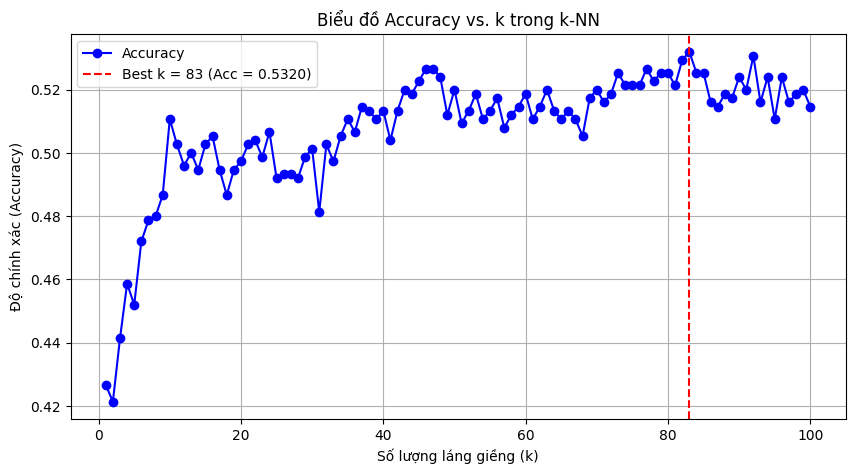

[INFO] Giá trị k tối ưu: 83, với độ chính xác cao nhất: 0.5320


In [43]:
# Nạp dữ liệu ảnh
print("[INFO] Nạp ảnh để train...")
imagePaths = list(paths.list_images("datasets/animals"))

# Tiền xử lý ảnh
sp = SimplePreprocessor(32, 32)
sdl = SimpleDatasetLoader(preprocessors=[sp])
(data, labels) = sdl.load(imagePaths, verbose=500)
data = data.reshape((data.shape[0], 3072))

print("[INFO] Dung lượng Ma trận đặc trưng: {:.1f}MB".format(data.nbytes / (1024 * 1000.0)))

# Mã hóa nhãn
le = LabelEncoder()
labels = le.fit_transform(labels)

# Chia dữ liệu thành tập train và test
(trainData, testData, trainLabel, testLabel) = train_test_split(data, labels, test_size=0.25, random_state=42)

print("[INFO] Đang đánh giá k-NN với các giá trị k từ 1 đến 100...")

# Tạo danh sách để lưu độ chính xác của từng k
accuracies = []

# Chạy mô hình k-NN với các giá trị k từ 1 đến 100
for k in range(1, 101):
    model = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    model.fit(trainData, trainLabel)
    acc = model.score(testData, testLabel)  # Đánh giá trên tập kiểm tra
    accuracies.append(acc)

# Tìm giá trị k có accuracy cao nhất
best_k = np.argmax(accuracies) + 1  # Vì index bắt đầu từ 0
best_acc = accuracies[best_k - 1]

# Vẽ biểu đồ
plt.figure(figsize=(10, 5))
plt.plot(range(1, 101), accuracies, marker="o", linestyle="-", color="b", label="Accuracy")
plt.xlabel("Số lượng láng giềng (k)")
plt.ylabel("Độ chính xác (Accuracy)")
plt.title("Biểu đồ Accuracy vs. k trong k-NN")

# Hiển thị k tốt nhất
plt.axvline(x=best_k, color="r", linestyle="--", label=f"Best k = {best_k} (Acc = {best_acc:.4f})")
plt.legend()
plt.grid(True)
plt.show()

print(f"[INFO] Giá trị k tối ưu: {best_k}, với độ chính xác cao nhất: {best_acc:.4f}")

In [44]:
print("[Đánh giá Bộ phân lớp k-NN ...]")
model = KNeighborsClassifier(n_neighbors=83, n_jobs=-1)
model.fit(trainData, trainLabel)

[Đánh giá Bộ phân lớp k-NN ...]


KNeighborsClassifier(n_jobs=-1, n_neighbors=83)

In [45]:
# Lưu file model
knnPickle = open('knnpickle_file.pkl', 'wb')
pickle.dump(model, knnPickle)

print(classification_report(testLabel, model.predict(testData), target_names=le.classes_))


              precision    recall  f1-score   support

         cat       0.55      0.46      0.50       262
         dog       0.41      0.67      0.51       249
       panda       0.90      0.47      0.62       239

    accuracy                           0.53       750
   macro avg       0.62      0.53      0.54       750
weighted avg       0.61      0.53      0.54       750



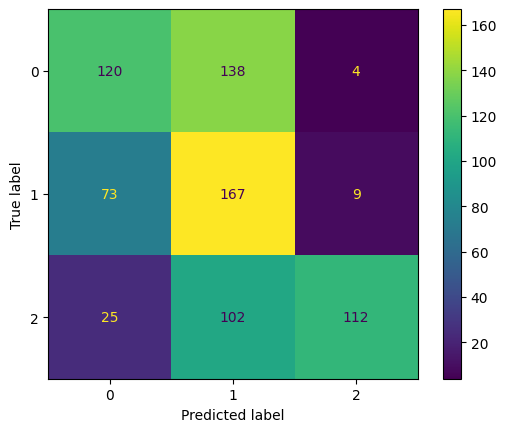

In [46]:
# Tạo và hiển thị ma trận confusion
cm = confusion_matrix(testLabel, model.predict(testData))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
show()

# Test ảnh

[INFO] Đang nạp ảnh mẫu để phân lớp...
[INFO] Nạp model mạng pre-trained ...
[INFO] Đang dự đoán để phân lớp...


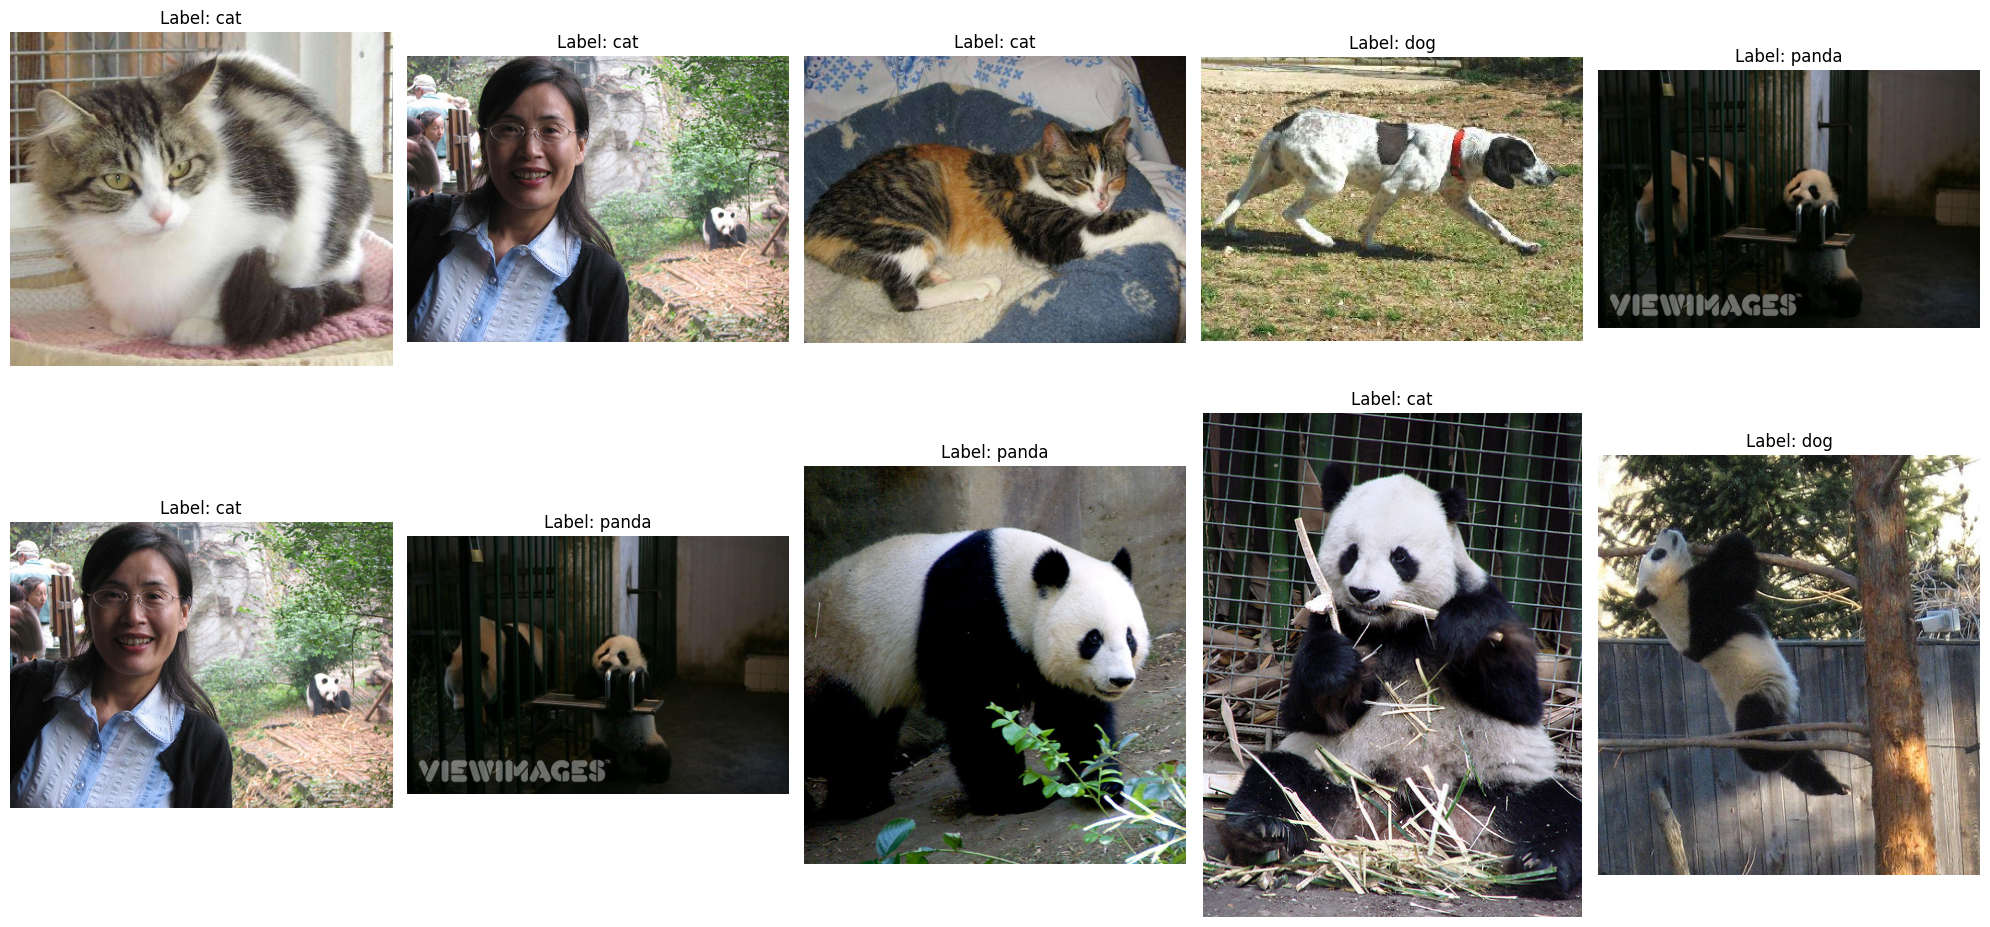

In [47]:
# Khởi tạo danh sách nhãn
classLabels = ["cat", "dog", "panda"]

# Lấy danh sách các hình ảnh trong tập dữ liệu
print("[INFO] Đang nạp ảnh mẫu để phân lớp...")
imagePaths = np.array(list(paths.list_images("image")))  # Xác định số file trong dataset (folder image)
idxs = np.random.randint(0, len(imagePaths), size=(10,))  # Chọn 10 ảnh ngẫu nhiên
imagePaths = imagePaths[idxs]

# Tiền xử lý dữ liệu ảnh
sp = SimplePreprocessor(32, 32)  # Thiết lập kích thước ảnh 32x32
iap = ImageToArrayPreprocessor()  # Gọi hàm để chuyển ảnh sang mảng

# Nạp dataset ảnh từ đĩa vào đối tượng data
sdl = SimpleDatasetLoader(preprocessors=[sp, iap])
(data, labels) = sdl.load(imagePaths)
data = data.reshape((data.shape[0], 3072))

# Nạp model đã được train (pre-trained)
print("[INFO] Nạp model mạng pre-trained ...")
model = pickle.load(open('knnpickle_file.pkl', 'rb'))

# Dự đoán nhãn ảnh đầu vào
print("[INFO] Đang dự đoán để phân lớp...")
preds = model.predict(data)

# Hiển thị kết quả trên Jupyter Notebook
plt.figure(figsize=(20, 10))

for i, imagePath in enumerate(imagePaths):
    image = cv2.imread(imagePath)  # Nạp ảnh
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Chuyển ảnh sang RGB để hiển thị đúng màu

    # Tạo nhãn dự đoán
    label = classLabels[preds[i]]
    
    # Vẽ ảnh lên matplotlib
    plt.subplot(2, 5, i + 1)  # 6 hàng, 6 cột
    plt.imshow(image)
    plt.title(f"Label: {label}")
    plt.axis("off")  # Ẩn trục tọa độ

plt.tight_layout()  # Căn chỉnh bố cục
plt.show()